# Modelo Predictivo

**Objetivo:** Predecir recursos en instituciones de salud

## EDA

In [46]:
# Librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from google.cloud import bigquery, bigquery_storage
import joblib
from categorify import Categorify

pd.set_option('display.max_columns', None)

## SetUp

In [2]:
# Constantes
GOLD_LAYER = '../data/gold'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'C:\Users\sebas\AppData\Roaming\gcloud\application_default_credentials.json'

client = bigquery.Client(project="predictive-health-resources")
bqstorage_client = bigquery_storage.BigQueryReadClient()

In [3]:
# Tu consulta: ajusta según tu dataset y tabla reales
facts = """
SELECT *
FROM `predictive-health-resources.healht_analytics_gold.fact_table_beds`
"""
time = """
SELECT *
FROM `predictive-health-resources.healht_analytics_gold.dim_time`
"""
place = """
SELECT *
FROM `predictive-health-resources.healht_analytics_gold.dim_place`
"""

In [4]:
fact_job = client.query(facts)
time_job = client.query(time)
place_job = client.query(place)

In [5]:
fact_table_beds = fact_job.to_dataframe(bqstorage_client=bqstorage_client)
dim_time = time_job.to_dataframe(bqstorage_client=bqstorage_client)
dim_place = place_job.to_dataframe(bqstorage_client=bqstorage_client)

In [6]:
for archivo in os.listdir(GOLD_LAYER):
    ruta_completa = os.path.join(GOLD_LAYER, archivo)
    if os.path.isfile(ruta_completa):
        tamaño_bytes = os.path.getsize(ruta_completa)
        tamaño_mb = tamaño_bytes / (1024 * 1024)
        print(f"{archivo:30} {tamaño_mb:10.2f} MB")


dim_patient_history.csv              2.83 MB
dim_place.csv                        0.01 MB
dim_time.csv                         0.02 MB
dim_weather.csv                      2.49 MB
fact_table_beds.csv                 57.37 MB
fact_table_days.csv                 25.17 MB


In [7]:
fact_table_beds.head() 

,id_time,id_place,id_weather,avg_personal_medico_general,avg_personal_medico_esp,avg_ginecoobstetras,avg_pediatras,avg_cirujanos,avg_internistas,avg_anestesiologos,avg_odontologos,avg_pasantes,avg_personal_hospital,avg_enfermeras_general,avg_enfermeras_esp,total_atencion_medica,avg_camas_hospitalizacion,avg_camas_atencion_temporal,avg_labs,avg_dias_estancia,pacientes_hospital,indicador_escasez_camas,nivel_escasez
0,91,13,226,207.0,86.0,22.0,14.0,16.0,11.0,13.0,0.0,0.0,396.0,117.0,3.0,0,120.0,44.0,0.0,372.0,1,0.006098,Adecuada
1,86,13,226,207.0,86.0,22.0,14.0,16.0,11.0,13.0,0.0,0.0,396.0,117.0,3.0,0,120.0,44.0,0.0,372.0,1,0.006098,Adecuada
2,69,13,226,207.0,86.0,22.0,14.0,16.0,11.0,13.0,0.0,0.0,396.0,117.0,3.0,0,120.0,44.0,0.0,372.0,1,0.006098,Adecuada
3,97,13,226,207.0,86.0,22.0,14.0,16.0,11.0,13.0,0.0,0.0,396.0,117.0,3.0,0,120.0,44.0,0.0,372.0,1,0.006098,Adecuada
4,98,13,226,207.0,86.0,22.0,14.0,16.0,11.0,13.0,0.0,0.0,396.0,117.0,3.0,0,120.0,44.0,0.0,372.0,1,0.006098,Adecuada


In [8]:
# Estadisticas de los datos númericos
fact_table_beds.describe()

,id_time,id_place,id_weather,avg_personal_medico_general,avg_personal_medico_esp,avg_ginecoobstetras,avg_pediatras,avg_cirujanos,avg_internistas,avg_anestesiologos,avg_odontologos,avg_pasantes,avg_personal_hospital,avg_enfermeras_general,avg_enfermeras_esp,total_atencion_medica,avg_camas_hospitalizacion,avg_camas_atencion_temporal,avg_labs,avg_dias_estancia,pacientes_hospital,indicador_escasez_camas
count,444739.0,444739.0,444739.0,444739.00000,444739.000000,444739.000000,444739.000000,444739.000000,444739.000000,444739.000000,444739.000000,444739.000000,444739.000000,444739.000000,444739.000000,444739.0,444739.000000,444739.000000,444739.000000,444739.000000,444739.0,444739.000000
mean,517.016996,32.826168,10758.331098,2111.62107,1137.821403,132.072917,91.674144,127.615359,58.467429,139.630520,4.714221,17.199670,2579.935962,485.929559,100.931254,287.115573,617.329944,232.654289,7.426898,75.462570,3.463753,0.015589
std,126.454257,20.398117,6674.874452,3173.63295,2016.523860,285.907606,183.669802,228.128431,124.394766,238.596569,5.041895,34.798527,2340.772756,422.952095,134.830570,698.154656,461.695859,210.825844,5.253716,127.420664,5.341232,0.066575
min,7.0,1.0,1.0,12.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,2.000000,0.000000,0.0,12.000000,0.000000,0.000000,0.000000,1.0,0.000252
25%,425.0,17.0,4973.0,453.00000,220.000000,27.000000,22.000000,23.000000,13.000000,18.000000,1.000000,0.000000,461.000000,118.000000,7.000000,23.0,262.000000,84.000000,4.000000,9.000000,1.0,0.001209
50%,522.0,26.0,10338.0,1385.00000,581.000000,58.000000,55.000000,74.000000,31.000000,58.000000,3.000000,4.000000,2555.000000,347.000000,75.000000,113.0,536.000000,178.000000,7.000000,21.000000,1.0,0.002976
75%,620.0,52.0,16424.0,3395.00000,1742.000000,149.000000,93.000000,126.000000,60.000000,194.000000,7.000000,21.000000,4071.000000,804.000000,130.000000,214.0,894.000000,368.000000,11.000000,59.000000,3.0,0.008604
max,731.0,72.0,23198.0,34351.00000,22167.000000,3174.000000,1955.000000,2064.000000,949.000000,2197.000000,18.000000,182.000000,16342.000000,2405.000000,773.000000,12840.0,2466.000000,1500.000000,31.000000,696.000000,71.0,1.785714


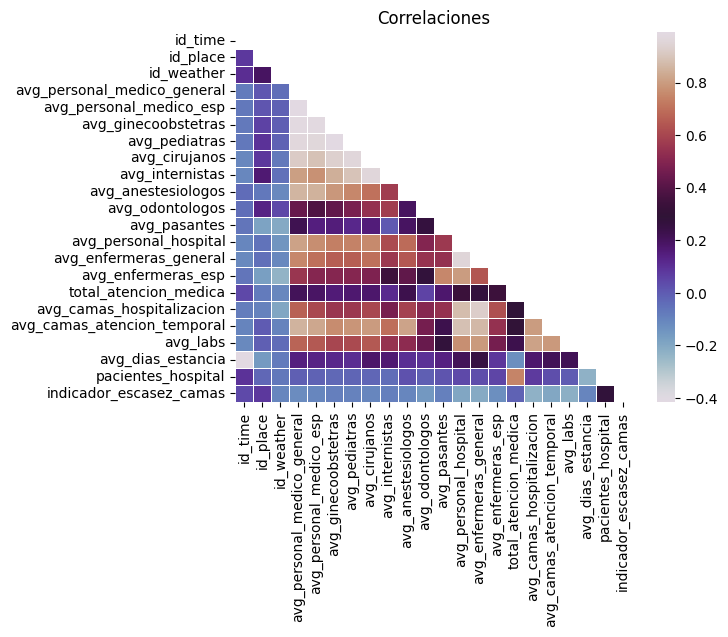

In [9]:
# Heatmap
corr = fact_table_beds.corr(numeric_only=True)  
mask = np.triu(np.ones_like(corr, dtype=bool))  
sns.heatmap(corr, cmap="twilight", fmt=".2f", mask=mask, linewidth=.5)
plt.title("Correlaciones")
plt.show()

In [10]:
corr['pacientes_hospital'].sort_values(ascending=False)

pacientes_hospital             1.000000
total_atencion_medica          0.746858
indicador_escasez_camas        0.277867
id_time                        0.093537
avg_camas_hospitalizacion      0.078658
avg_enfermeras_esp             0.053163
avg_personal_hospital          0.041106
avg_enfermeras_general         0.030454
avg_camas_atencion_temporal    0.030223
avg_anestesiologos             0.025791
avg_pasantes                   0.018368
avg_labs                       0.000885
avg_personal_medico_general   -0.007803
avg_odontologos               -0.007917
avg_personal_medico_esp       -0.016110
avg_pediatras                 -0.020757
avg_cirujanos                 -0.023127
id_place                      -0.027540
avg_ginecoobstetras           -0.030108
avg_internistas               -0.039863
id_weather                    -0.068258
avg_dias_estancia             -0.228152
Name: pacientes_hospital, dtype: float64

## Check Variables

In [11]:
dim_time.head()

,id_time,fecha,year,quarter,month,day,weekday
0,2,2023-01-02,2023,1,1,2,1
1,9,2023-01-09,2023,1,1,9,1
2,16,2023-01-16,2023,1,1,16,1
3,23,2023-01-23,2023,1,1,23,1
4,30,2023-01-30,2023,1,1,30,1


In [12]:
dim_time['fecha'] = pd.to_datetime(dim_time['fecha'])
dim_time[dim_time['fecha']<'2024-01-01']

,id_time,fecha,year,quarter,month,day,weekday
0,2,2023-01-02,2023,1,1,2,1
1,9,2023-01-09,2023,1,1,9,1
2,16,2023-01-16,2023,1,1,16,1
3,23,2023-01-23,2023,1,1,23,1
4,30,2023-01-30,2023,1,1,30,1
...,...,...,...,...,...,...,...
360,337,2023-12-03,2023,4,12,3,7
361,344,2023-12-10,2023,4,12,10,7
362,351,2023-12-17,2023,4,12,17,7
363,358,2023-12-24,2023,4,12,24,7


In [13]:
fact_table_beds.id_place.nunique(), fact_table_beds.id_time.nunique(), fact_table_beds.id_weather.nunique()

(72, 725, 23198)

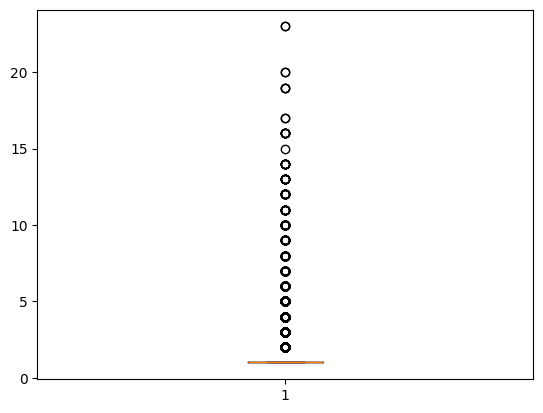

In [14]:
test = fact_table_beds[(fact_table_beds['id_time']<365)][['id_time','pacientes_hospital']]
plt.boxplot(test.pacientes_hospital)
plt.show()

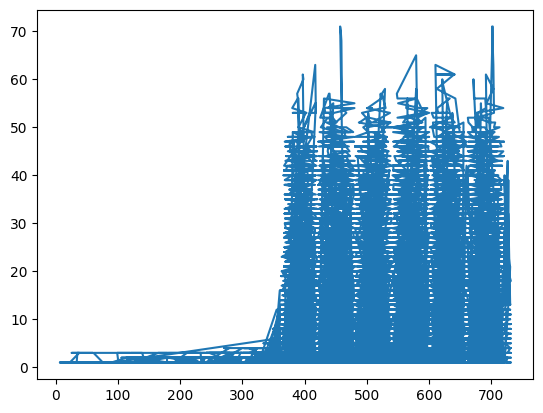

In [15]:
plt.plot(fact_table_beds.id_time, fact_table_beds.pacientes_hospital)
plt.show()

In [16]:
fact_test = fact_table_beds.drop(columns=['id_weather','indicador_escasez_camas','nivel_escasez'])

# Separar las columnas
avg_cols = [col for col in fact_test.columns if col.startswith('avg_')]
sum_cols = ['total_atencion_medica', 'pacientes_hospital']

# Crear diccionario de agregaciones
agg_dict = {col: 'mean' for col in avg_cols}
agg_dict.update({col: 'sum' for col in sum_cols})

# Agrupar y aplicar agregaciones
fact_grouped = fact_test.groupby(['id_time', 'id_place']).agg(agg_dict).reset_index()
fact_filtered = fact_grouped[fact_grouped['id_time']>365]
fact_filtered.head()

,id_time,id_place,avg_personal_medico_general,avg_personal_medico_esp,avg_ginecoobstetras,avg_pediatras,avg_cirujanos,avg_internistas,avg_anestesiologos,avg_odontologos,avg_pasantes,avg_personal_hospital,avg_enfermeras_general,avg_enfermeras_esp,avg_camas_hospitalizacion,avg_camas_atencion_temporal,avg_labs,avg_dias_estancia,total_atencion_medica,pacientes_hospital
6404,366,1,1523.0,757.0,61.0,72.0,85.0,31.0,58.0,1.0,6.0,2596.0,494.0,43.0,464.0,238.0,12.0,12.378968,2288,26
6405,366,2,227.0,98.0,6.0,7.0,16.0,6.0,3.0,5.0,0.0,287.0,74.0,2.0,90.0,46.0,1.0,23.946825,1189,41
6406,366,3,337.0,176.0,27.0,15.0,25.0,15.0,0.0,4.0,2.0,424.0,90.0,24.0,114.0,42.0,3.0,11.457778,836,38
6407,366,4,261.0,131.0,26.0,8.0,11.0,7.0,19.0,3.0,0.0,216.0,42.0,7.0,86.0,36.0,2.0,40.142857,108,9
6408,366,6,498.0,287.0,39.0,29.0,24.0,11.0,38.0,1.0,1.0,454.0,99.0,10.0,118.0,106.0,5.0,14.157407,272,17


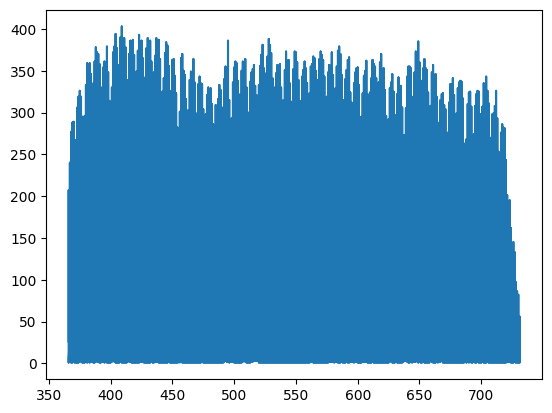

In [17]:
plt.plot(fact_filtered.id_time, fact_filtered.pacientes_hospital)
plt.show()

In [18]:
len(fact_filtered)

25311

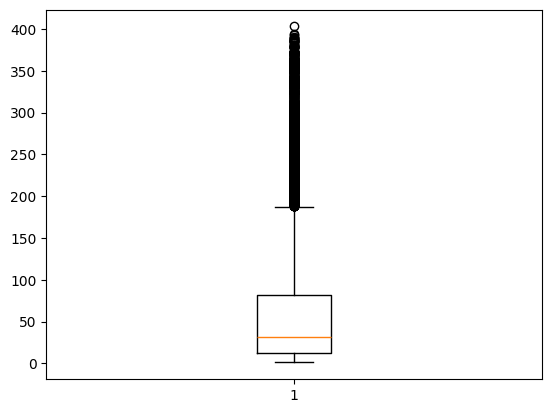

In [19]:
plt.boxplot(fact_filtered.pacientes_hospital)
plt.show()

In [20]:
fact_filtered.pacientes_hospital.describe()

count      25311.0
mean     58.615069
std      68.928851
min            1.0
25%           12.0
50%           31.0
75%           82.0
max          403.0
Name: pacientes_hospital, dtype: Float64

## Selección de variables

Mediante un RandomForest

In [21]:
X = fact_filtered.drop(columns=['pacientes_hospital'])
y = fact_filtered['pacientes_hospital']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

s_model = RandomForestRegressor(
    n_estimators=100,
    random_state=1
)
s_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Importancias y Resultados Modelo

In [22]:
importancias = s_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'feature':features,'importances':importancias})
importance_df = importance_df.sort_values(by='importances', ascending=False)
importance_df

,feature,importances
18,total_atencion_medica,0.670883
16,avg_labs,0.065857
17,avg_dias_estancia,0.063458
2,avg_personal_medico_general,0.033621
11,avg_personal_hospital,0.032185
13,avg_enfermeras_esp,0.027733
1,id_place,0.021656
3,avg_personal_medico_esp,0.020402
15,avg_camas_atencion_temporal,0.012276
14,avg_camas_hospitalizacion,0.008238


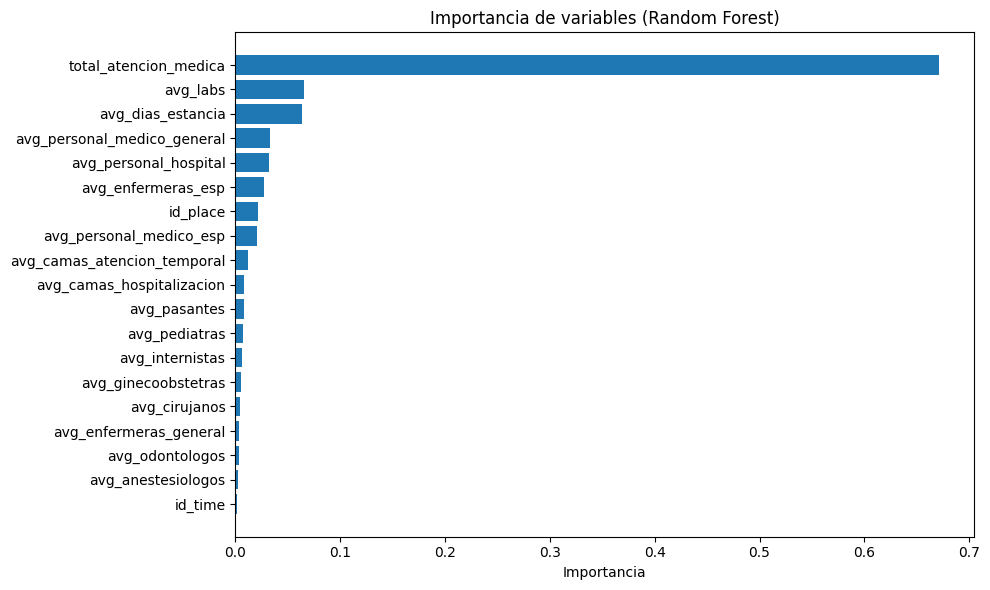

In [23]:
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'],importance_df['importances'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables (Random Forest)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

In [24]:
y_preds = s_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_preds)
print(f'{rmse=}')

rmse=1.9045769067587273


In [25]:
y_test.describe()

count       5063.0
mean     58.940549
std      68.812426
min            1.0
25%           12.0
50%           31.0
75%           83.0
max          403.0
Name: pacientes_hospital, dtype: Float64

## Desempaquetando Modelo

In [26]:
dim_place.head()

,id_place,clave_entidad,nombre_entidad,clave_municipio,nombre_municipio,clave_localidad,nombre_localidad,lat_decimal,lon_decimal,codigo_postal,clues,nivel_atencion
0,1,2,Baja California,2,Mexicali,1,Mexicali,32.641176,-115.475578,21000,BCIST000040,SEGUNDO NIVEL
1,2,3,Baja California Sur,3,La Paz,1,La Paz,24.148745,-110.306590,23090,BSIST000330,SEGUNDO NIVEL
2,3,4,Campeche,2,Campeche,1,San Francisco de Campeche,19.844814,-90.539649,24030,CCIST000021,SEGUNDO NIVEL
3,4,4,Campeche,3,Carmen,1,Ciudad del Carmen,18.637789,-91.836450,24180,CCIST000033,SEGUNDO NIVEL
4,5,5,Coahuila De Zaragoza,2,Acuña,1,Ciudad Acuna,29.330005,-100.978258,26260,CLIST000012,PRIMER NIVEL


In [27]:
fact_time = pd.merge(fact_filtered, dim_time[['id_time','year','quarter','month','day','weekday']], on='id_time', how='inner')
fact_time_place = pd.merge(
    fact_time, 
    dim_place[['id_place','nombre_entidad','nombre_municipio','nombre_localidad','codigo_postal']],
    on='id_place',
    how='inner'    
)
data = fact_time_place.drop(columns=['id_time','id_place'])
data.head()

,avg_personal_medico_general,avg_personal_medico_esp,avg_ginecoobstetras,avg_pediatras,avg_cirujanos,avg_internistas,avg_anestesiologos,avg_odontologos,avg_pasantes,avg_personal_hospital,avg_enfermeras_general,avg_enfermeras_esp,avg_camas_hospitalizacion,avg_camas_atencion_temporal,avg_labs,avg_dias_estancia,total_atencion_medica,pacientes_hospital,year,quarter,month,day,weekday,nombre_entidad,nombre_municipio,nombre_localidad,codigo_postal
0,1523.0,757.0,61.0,72.0,85.0,31.0,58.0,1.0,6.0,2596.0,494.0,43.0,464.0,238.0,12.0,12.378968,2288,26,2024,1,1,1,1,Baja California,Mexicali,Mexicali,21000
1,227.0,98.0,6.0,7.0,16.0,6.0,3.0,5.0,0.0,287.0,74.0,2.0,90.0,46.0,1.0,23.946825,1189,41,2024,1,1,1,1,Baja California Sur,La Paz,La Paz,23090
2,337.0,176.0,27.0,15.0,25.0,15.0,0.0,4.0,2.0,424.0,90.0,24.0,114.0,42.0,3.0,11.457778,836,38,2024,1,1,1,1,Campeche,Campeche,San Francisco de Campeche,24030
3,261.0,131.0,26.0,8.0,11.0,7.0,19.0,3.0,0.0,216.0,42.0,7.0,86.0,36.0,2.0,40.142857,108,9,2024,1,1,1,1,Campeche,Carmen,Ciudad del Carmen,24180
4,498.0,287.0,39.0,29.0,24.0,11.0,38.0,1.0,1.0,454.0,99.0,10.0,118.0,106.0,5.0,14.157407,272,17,2024,1,1,1,1,Coahuila De Zaragoza,Monclova,Monclova,25734


## Entrenamiento sin desempaquetar

In [28]:
fact_filtered.loc[:,'id_place'] = fact_filtered['id_place'].astype('category')
fact_filtered.loc[:,'id_time'] = fact_filtered['id_time'].astype('category')

In [29]:
X = fact_filtered.drop(columns=['pacientes_hospital'])
y = fact_filtered['pacientes_hospital']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.05,
    random_state=1,
    verbose=-1
)
model.fit(
    X_train, y_train,
    categorical_feature=['id_place', 'id_time'],
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAE: {mae:.2f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 3.0993	valid_0's l2: 9.60564
✅ RMSE: 9.61
✅ MAE: 1.73


## Entrenamiento Desempaquetando

In [30]:
categorical_cols = [
    'year', 'quarter', 'month', 'day', 'weekday', 
    'nombre_entidad', 'nombre_municipio', 'nombre_localidad', 'codigo_postal'
]

data[categorical_cols] = data[categorical_cols].astype('category')

In [31]:
X = data.drop(columns=['pacientes_hospital'])
y = data['pacientes_hospital']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.05,
    random_state=1,
    verbose=-1
)
model.fit(
    X_train, y_train,
    categorical_feature=categorical_cols,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAE: {mae:.2f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 2.63856	valid_0's l2: 6.962
✅ RMSE: 6.96
✅ MAE: 1.43


## Agregando mas features al modelo desempaquetado

In [32]:
fact_time2 = pd.merge(fact_filtered, dim_time[['id_time','fecha','year','quarter','month','day','weekday']], on='id_time', how='inner')
fact_time_place2 = pd.merge(
    fact_time2, 
    dim_place[['id_place','nombre_entidad','nombre_municipio','nombre_localidad','codigo_postal']],
    on='id_place',
    how='inner'    
)

fact_time_place2 = fact_time_place2.sort_values(['id_place', 'fecha']).copy()

fact_time_place2['lag_1'] = fact_time_place2.groupby('id_place')['pacientes_hospital'].shift(1)
fact_time_place2['delta_1'] = fact_time_place2['pacientes_hospital'] - fact_time_place2['lag_1']
fact_time_place2['rolling_mean_3'] = (
    fact_time_place2
    .groupby('id_place')['pacientes_hospital']
    .shift(1)
    .rolling(window=3)
    .mean()
    .reset_index(0, drop=True)
)

fact_time_place2 = fact_time_place2.dropna(subset=['lag_1', 'delta_1', 'rolling_mean_3'])

categorical_cols = [
    'year', 'quarter', 'month', 'day', 'weekday',
    'nombre_entidad', 'nombre_municipio', 'nombre_localidad', 'codigo_postal'
]

fact_time_place2[categorical_cols] = fact_time_place2[categorical_cols].astype('category')

data2 = fact_time_place2.drop(columns=['id_time', 'id_place', 'fecha'])
data2

,avg_personal_medico_general,avg_personal_medico_esp,avg_ginecoobstetras,avg_pediatras,avg_cirujanos,avg_internistas,avg_anestesiologos,avg_odontologos,avg_pasantes,avg_personal_hospital,avg_enfermeras_general,avg_enfermeras_esp,avg_camas_hospitalizacion,avg_camas_atencion_temporal,avg_labs,avg_dias_estancia,total_atencion_medica,pacientes_hospital,year,quarter,month,day,weekday,nombre_entidad,nombre_municipio,nombre_localidad,codigo_postal,lag_1,delta_1,rolling_mean_3
66,1523.0,757.0,61.0,72.0,85.0,31.0,58.0,1.0,6.0,2596.0,494.0,43.0,464.0,238.0,12.0,12.045635,2816,32,2024,1,1,2,2,Baja California,Mexicali,Mexicali,21000,26,6,46.333333
132,1523.0,757.0,61.0,72.0,85.0,31.0,58.0,1.0,6.0,2596.0,494.0,43.0,464.0,238.0,12.0,13.296970,2640,30,2024,1,1,3,3,Baja California,Mexicali,Mexicali,21000,32,-2,36.333333
200,1523.0,757.0,61.0,72.0,85.0,31.0,58.0,1.0,6.0,2596.0,494.0,43.0,464.0,238.0,12.0,13.001389,2992,34,2024,1,1,4,4,Baja California,Mexicali,Mexicali,21000,30,4,34.666667
267,1523.0,757.0,61.0,72.0,85.0,31.0,58.0,1.0,6.0,2596.0,494.0,43.0,464.0,238.0,12.0,11.973611,3168,36,2024,1,1,5,5,Baja California,Mexicali,Mexicali,21000,34,2,40.333333
333,1523.0,757.0,61.0,72.0,85.0,31.0,58.0,1.0,6.0,2596.0,494.0,43.0,464.0,238.0,12.0,12.854167,3168,36,2024,1,1,6,6,Baja California,Mexicali,Mexicali,21000,36,0,49.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25046,412.0,242.0,27.0,14.0,23.0,9.0,25.0,0.0,6.0,323.0,62.0,4.0,142.0,24.0,3.0,2.833333,49,7,2024,4,12,27,5,Zacatecas,Fresnillo,Fresnillo,99020,9,-2,7.000000
25113,412.0,242.0,27.0,14.0,23.0,9.0,25.0,0.0,6.0,323.0,62.0,4.0,142.0,24.0,3.0,3.000000,63,9,2024,4,12,28,6,Zacatecas,Fresnillo,Fresnillo,99020,7,2,10.666667
25180,412.0,242.0,27.0,14.0,23.0,9.0,25.0,0.0,6.0,323.0,62.0,4.0,142.0,24.0,3.0,3.000000,49,7,2024,4,12,29,7,Zacatecas,Fresnillo,Fresnillo,99020,9,-2,12.000000
25247,412.0,242.0,27.0,14.0,23.0,9.0,25.0,0.0,6.0,323.0,62.0,4.0,142.0,24.0,3.0,2.625000,49,7,2024,4,12,30,1,Zacatecas,Fresnillo,Fresnillo,99020,7,0,12.333333


In [33]:
# --- 7. Separa features y target ---
X2 = data2.drop(columns=['pacientes_hospital'])
y2 = data2['pacientes_hospital']

In [34]:
# --- 8. Split train/test ---
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=1
)

# --- 9. Entrena LightGBM ---
model2 = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.05,
    random_state=1,
    verbose=-1
)

model2.fit(
    X2_train, y2_train,
    categorical_feature=categorical_cols,
    eval_set=[(X2_test, y2_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# --- 10. Evalúa el modelo ---
y2_pred = model2.predict(X2_test)
rmse2 = mean_squared_error(y2_test, y2_pred)
mae2 = mean_absolute_error(y2_test, y2_pred)

print(f"✅ RMSE: {rmse2:.2f}")
print(f"✅ MAE: {mae2:.2f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.732162	valid_0's l2: 0.536061
✅ RMSE: 0.54
✅ MAE: 0.34


## Verificación Overfitting

In [35]:
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X2, y2, test_size=0.2, random_state=1, shuffle=False
)

In [36]:
model3 = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.05,
    random_state=1,
    verbose=-1
)

model3.fit(
    X3_train, y3_train,
    categorical_feature=categorical_cols,
    eval_set=[(X3_test, y3_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

y3_pred = model3.predict(X3_test)
rmse3 = mean_squared_error(y3_test, y3_pred)
mae3 = mean_absolute_error(y3_test, y3_pred)

print(f"✅ RMSE: {rmse3:.2f}")
print(f"✅ MAE: {mae3:.2f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's rmse: 0.716069	valid_0's l2: 0.512755
✅ RMSE: 0.51
✅ MAE: 0.45


## Revision de datos para producción

In [37]:
data2.describe()

,avg_personal_medico_general,avg_personal_medico_esp,avg_ginecoobstetras,avg_pediatras,avg_cirujanos,avg_internistas,avg_anestesiologos,avg_odontologos,avg_pasantes,avg_personal_hospital,avg_enfermeras_general,avg_enfermeras_esp,avg_camas_hospitalizacion,avg_camas_atencion_temporal,avg_labs,avg_dias_estancia,total_atencion_medica,pacientes_hospital,lag_1,delta_1,rolling_mean_3
count,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.0,25026.0,25026.0,25026.0,25026.000000
mean,1608.646488,891.264045,109.832254,75.578518,93.734077,44.695437,98.858108,3.674499,9.447095,1712.133701,321.228123,65.214976,426.479022,156.433150,5.790618,33.471944,4836.68249,58.749061,58.839007,-0.089946,58.971043
std,4197.794097,2696.963541,384.389663,239.561577,265.803388,129.295039,279.611480,4.709302,25.491096,2494.936594,416.914018,130.454977,464.820962,228.174933,5.689968,46.770435,9646.09631,69.031598,69.047609,7.540348,68.964641
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,2.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,-71.0,1.000000
25%,250.000000,108.000000,12.000000,11.000000,12.000000,7.000000,12.000000,0.000000,0.000000,299.000000,69.000000,3.000000,112.000000,18.000000,2.000000,8.250000,66.0,12.0,12.0,-3.0,11.666667
50%,518.000000,253.000000,30.000000,22.000000,24.000000,16.000000,24.000000,2.000000,0.000000,474.000000,126.000000,11.000000,278.000000,84.000000,5.000000,17.195181,675.0,31.0,31.0,0.0,30.666667
75%,1414.000000,670.000000,62.000000,59.000000,83.000000,32.000000,70.000000,5.000000,6.000000,2596.000000,380.000000,75.000000,552.000000,204.000000,8.000000,32.768317,4392.0,82.0,82.0,3.0,82.666667
max,34351.000000,22167.000000,3174.000000,1955.000000,2064.000000,949.000000,2197.000000,18.000000,182.000000,16342.000000,2405.000000,773.000000,2466.000000,1500.000000,31.000000,312.000000,60047.0,403.0,403.0,64.0,393.333333


In [38]:
data2.pacientes_hospital.describe()

count      25026.0
mean     58.749061
std      69.031598
min            1.0
25%           12.0
50%           31.0
75%           82.0
max          403.0
Name: pacientes_hospital, dtype: Float64

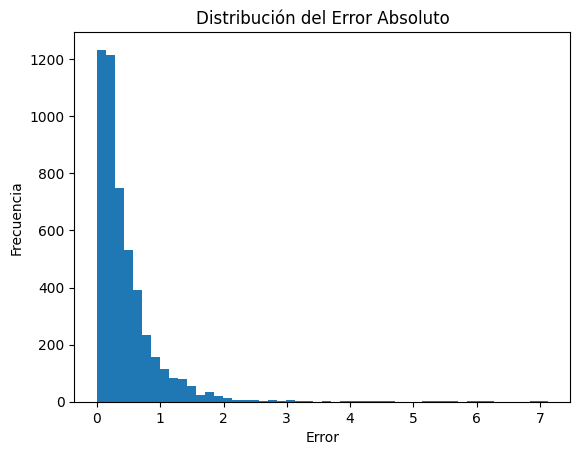

In [39]:
errors = abs(y3_pred - y3_test)
plt.hist(errors, bins=50)
plt.title("Distribución del Error Absoluto")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.show()

## Haciendo predicciones

In [40]:
X2.describe()

,avg_personal_medico_general,avg_personal_medico_esp,avg_ginecoobstetras,avg_pediatras,avg_cirujanos,avg_internistas,avg_anestesiologos,avg_odontologos,avg_pasantes,avg_personal_hospital,avg_enfermeras_general,avg_enfermeras_esp,avg_camas_hospitalizacion,avg_camas_atencion_temporal,avg_labs,avg_dias_estancia,total_atencion_medica,lag_1,delta_1,rolling_mean_3
count,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.000000,25026.0,25026.0,25026.0,25026.000000
mean,1608.646488,891.264045,109.832254,75.578518,93.734077,44.695437,98.858108,3.674499,9.447095,1712.133701,321.228123,65.214976,426.479022,156.433150,5.790618,33.471944,4836.68249,58.839007,-0.089946,58.971043
std,4197.794097,2696.963541,384.389663,239.561577,265.803388,129.295039,279.611480,4.709302,25.491096,2494.936594,416.914018,130.454977,464.820962,228.174933,5.689968,46.770435,9646.09631,69.047609,7.540348,68.964641
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,2.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.0,1.0,-71.0,1.000000
25%,250.000000,108.000000,12.000000,11.000000,12.000000,7.000000,12.000000,0.000000,0.000000,299.000000,69.000000,3.000000,112.000000,18.000000,2.000000,8.250000,66.0,12.0,-3.0,11.666667
50%,518.000000,253.000000,30.000000,22.000000,24.000000,16.000000,24.000000,2.000000,0.000000,474.000000,126.000000,11.000000,278.000000,84.000000,5.000000,17.195181,675.0,31.0,0.0,30.666667
75%,1414.000000,670.000000,62.000000,59.000000,83.000000,32.000000,70.000000,5.000000,6.000000,2596.000000,380.000000,75.000000,552.000000,204.000000,8.000000,32.768317,4392.0,82.0,3.0,82.666667
max,34351.000000,22167.000000,3174.000000,1955.000000,2064.000000,949.000000,2197.000000,18.000000,182.000000,16342.000000,2405.000000,773.000000,2466.000000,1500.000000,31.000000,312.000000,60047.0,403.0,64.0,393.333333


In [41]:
X2.select_dtypes(include='category').describe()

,year,quarter,month,day,weekday,nombre_entidad,nombre_municipio,nombre_localidad,codigo_postal
count,25026,25026,25026,25026,25026,25026,25026,25026,25026
unique,1,4,12,31,7,28,68,69,72
top,2024,4,10,2,2,Ciudad De México,Benito Juarez,Alvaro Obregon,72570
freq,25026,6366,2152,832,3639,2544,1089,727,365


In [42]:
ejemplo1 = {
    'avg_personal_medico_general': 3000,
    'avg_personal_medico_esp': 1500,
    'avg_ginecoobstetras': 120,
    'avg_pediatras': 100,
    'avg_cirujanos': 110,
    'avg_internistas': 60,
    'avg_anestesiologos': 130,
    'avg_odontologos': 10,
    'avg_pasantes': 20,
    'avg_personal_hospital': 3500,
    'avg_enfermeras_general': 600,
    'avg_enfermeras_esp': 130,
    'avg_camas_hospitalizacion': 700,
    'avg_camas_atencion_temporal': 250,
    'avg_labs': 10,
    'avg_dias_estancia': 40,
    'total_atencion_medica': 9000,
    'lag_1': 80,
    'delta_1': 5,
    'rolling_mean_3': 85,
    'year': 2024,
    'quarter': 4,
    'month': 10,
    'day': 15,
    'weekday': 1,
    'nombre_entidad': 'Ciudad De México',
    'nombre_municipio': 'Benito Juarez',
    'nombre_localidad': 'Alvaro Obregon',
    'codigo_postal': '72570'
}

ejemplo2 = ejemplo1.copy()
ejemplo2.update({
    'avg_personal_medico_general': 100,
    'avg_personal_medico_esp': 50,
    'avg_ginecoobstetras': 5,
    'avg_pediatras': 3,
    'avg_cirujanos': 2,
    'avg_personal_hospital': 120,
    'avg_enfermeras_general': 40,
    'avg_camas_hospitalizacion': 50,
    'avg_camas_atencion_temporal': 10,
    'total_atencion_medica': 200,
    'lag_1': 10,
    'delta_1': -1,
    'rolling_mean_3': 9
})

ejemplo3 = ejemplo1.copy()
ejemplo3.update({
    'avg_personal_medico_general': 800,
    'avg_personal_medico_esp': 400,
    'avg_pediatras': 30,
    'avg_camas_hospitalizacion': 300,
    'avg_camas_atencion_temporal': 50,
    'total_atencion_medica': 2500,
    'lag_1': 45,
    'delta_1': 10,
    'rolling_mean_3': 40
})

pred_temp = pd.DataFrame([ejemplo1, ejemplo2, ejemplo3])
pred_temp

,avg_personal_medico_general,avg_personal_medico_esp,avg_ginecoobstetras,avg_pediatras,avg_cirujanos,avg_internistas,avg_anestesiologos,avg_odontologos,avg_pasantes,avg_personal_hospital,avg_enfermeras_general,avg_enfermeras_esp,avg_camas_hospitalizacion,avg_camas_atencion_temporal,avg_labs,avg_dias_estancia,total_atencion_medica,lag_1,delta_1,rolling_mean_3,year,quarter,month,day,weekday,nombre_entidad,nombre_municipio,nombre_localidad,codigo_postal
0,3000,1500,120,100,110,60,130,10,20,3500,600,130,700,250,10,40,9000,80,5,85,2024,4,10,15,1,Ciudad De México,Benito Juarez,Alvaro Obregon,72570
1,100,50,5,3,2,60,130,10,20,120,40,130,50,10,10,40,200,10,-1,9,2024,4,10,15,1,Ciudad De México,Benito Juarez,Alvaro Obregon,72570
2,800,400,120,30,110,60,130,10,20,3500,600,130,300,50,10,40,2500,45,10,40,2024,4,10,15,1,Ciudad De México,Benito Juarez,Alvaro Obregon,72570


In [43]:
pred_temp[categorical_cols] = pred_temp[categorical_cols].astype('category')
predicciones = model3.predict(pred_temp)
predicciones

array([4.09128518, 4.08435077, 4.08938298])

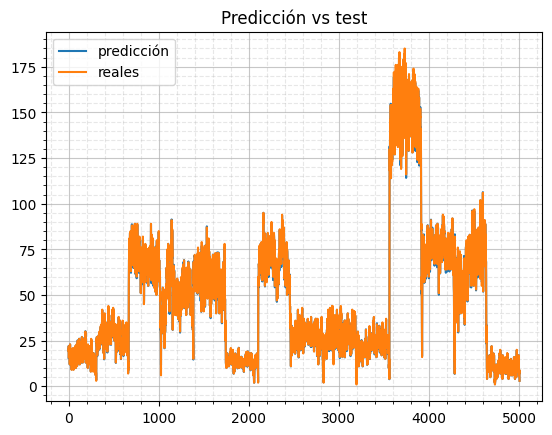

In [44]:
plt.title('Predicción vs test')
plt.plot(y3_pred, label='predicción')
plt.plot(y3_test.array, label='reales')
plt.minorticks_on()
plt.grid(which='major', alpha=0.7)
plt.grid(which='minor', linestyle='--',alpha=0.3)
plt.legend()
plt.show()

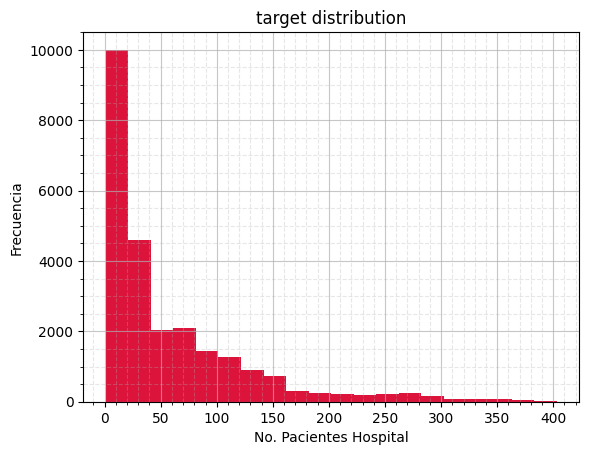

In [45]:
plt.title('target distribution')
plt.hist(data2.pacientes_hospital, bins=20, color='crimson')
plt.xlabel('No. Pacientes Hospital')
plt.ylabel('Frecuencia')
plt.minorticks_on()
plt.grid(which='major', alpha=0.7)
plt.grid(which='minor', linestyle='--',alpha=0.3)
plt.show();

## Creación de Pipeline

In [47]:
categorical_cols = [
    'year', 'quarter', 'month', 'day', 'weekday', 
    'nombre_entidad', 'nombre_municipio', 'nombre_localidad', 'codigo_postal'
]

data[categorical_cols] = data[categorical_cols].astype('category')

pipeline = Pipeline(
    steps=[
        ('categorify',Categorify(cat_columns = categorical_cols)),
        (
            'model', 
            lgb.LGBMRegressor(
                objective='regression',
                n_estimators=500,
                learning_rate=0.05,
                random_state=1,
                verbose=-1
            )
        )
    ]
)

pipeline.fit(
    X3_train, y3_train,
    model__categorical_feature = categorical_cols,
    model__eval_set=[(X3_test, y3_test)],
    model__eval_metric='rmse',
    model__callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

pipe_pred = pipeline.predict(X3_test)
rmse3 = mean_squared_error(y3_test, y3_pred)
mae3 = mean_absolute_error(y3_test, y3_pred)

print(f"✅ RMSE: {rmse3:.2f}")
print(f"✅ MAE: {mae3:.2f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's rmse: 0.716069	valid_0's l2: 0.512755
✅ RMSE: 0.51
✅ MAE: 0.45


In [48]:
pred_temp2 = pd.DataFrame([ejemplo1, ejemplo2, ejemplo3])
pipe_pred2 = pipeline.predict(pred_temp2)
pipe_pred2

array([4.09128518, 4.08435077, 4.08938298])

## Exportar modelo

In [49]:
os.makedirs('outputs/', exist_ok=True)
joblib.dump(pipeline, 'outputs/model.pkl')

['outputs/model.pkl']